In [1]:
# !pip3 install sklearn
# !pip3 install tqdm
# !pip3 install tensorboardX
!pip3 install timm
!pip3 install torchmetrics

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch import optim
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorboardX import SummaryWriter
from timm.utils import AverageMeter
from sklearn.model_selection import KFold
import random
import torchmetrics
# from models.vgg import vgg

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File paths to the data

In [3]:
# Kaggle
annotation_file_path = "../input/sorghum-id-fgvc-9/train_cultivar_mapping.csv"
img_dir_path = "../input/sorghum-id-fgvc-9/train_images"

# DeepNote
annotation_file_path = "data/train_cultivar_mapping.csv"
img_dir_path = "data/train_images"

Code for Resnet

In [4]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

__all__ = ['ResNet', 'resnet']


model_urls = {
    'resnet18': 'http://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'http://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'http://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'http://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'http://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def cfg(depth):
    depth_lst = [9, 18, 34, 50, 101, 152]
    assert (depth in depth_lst), "Error : ResNet depth should be either 18, 34, 50, 101, 152"
    cf_dict = {
        '9' : (BasicBlock, [1,1, 1,1]),
        '18' : (BasicBlock, [2,2, 2,2]),
        '34' : (BasicBlock, [3,4, 6,3]),
        '50' : (Bottleneck, [3,4, 6,3]),
        '101': (Bottleneck, [3,4,23,3]),
        '152': (Bottleneck, [3,8,36,3]),
    }

    return cf_dict[str(depth)]


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, sln=False):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.sln = sln
        # for the registration hook
        self.gradients = None
        self.activation = None

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        if sln:
            #self.fc_sln1 = nn.Linear(512 * 4 * 2, 512)
            self.conv_sln1 = nn.Conv2d(512*block.expansion, 512, 3, 2, 1) # (4, 7)
            #self.dropout1 = nn.Dropout(0.1)
            self.conv_sln2 = nn.Conv2d(512, 256, 3, 2, 1) # (2, 4)
            self.conv_sln3 = nn.Conv2d(256, 128, 3, 2, 1) # (1, 2)
            #self.dropout2 = nn.Dropout(0.1)
            #self.fc_sln2 = nn.Linear(512, 128)
            #self.dropout3 = nn.Dropout(0.1)
            self.fc_sln3 = nn.Linear(128*2, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def activations_hook(self, grad):
        self.gradients = grad


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        if self.sln:
            x = self.relu(self.conv_sln1(x))
            #x = self.dropout1(x)
            x = self.relu(self.conv_sln2(x))

            self.activation = x
            x.register_hook(self.activations_hook)

            #x = self.dropout2(x)
            x = self.relu(self.conv_sln3(x))
            #x = self.dropout3(x)

            x = x.view(x.size(0), -1)
            x = self.fc_sln3(x)
            return x
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self):
        return self.activation


def resnet(pretrained=False, depth=34, sln_head=False, **kwargs):
    """Constructs ResNet models for various depths
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        depth (int) : Integer input of either 18, 34, 50, 101, 152
    """
    block, num_blocks = cfg(depth)
    model = ResNet(block, num_blocks, sln=sln_head, **kwargs)
    if (pretrained):
        if sln_head:
            print("| Downloading ImageNet fine-tuned ResNet-%d..." %depth)
            model.load_state_dict(model_zoo.load_url(model_urls['resnet%d' %depth]), strict=False)
        else:
            print("| Downloading ImageNet fine-tuned ResNet-%d..." %depth)
            model.load_state_dict(model_zoo.load_url(model_urls['resnet%d' %depth]), strict=False)
            
    model.fc = nn.Sequential(nn.Linear(model.fc.in_features * 7 * 7, 100))
    return model


<AxesSubplot:>

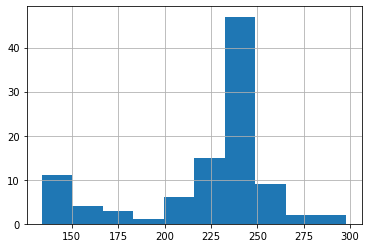

In [5]:
data = pd.read_csv(annotation_file_path)
data.cultivar.value_counts().hist()

In [6]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
from sklearn import preprocessing

class CultivarDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, )
        
        # remove this row, which the data preparer probably thought was funny to include
        self.img_labels = self.img_labels[self.img_labels["image"].str.contains(".DS_Store")==False]
        print(self.img_labels)
        
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # one-hot encoding (very messy)
        self.onehotenc = preprocessing.OneHotEncoder()
        self.onehotenc.fit([[i] for i in self.img_labels['cultivar'].tolist()])
        
        # one-hot encoding (very messy)
        self.labelenc = preprocessing.LabelEncoder()
        self.labelenc.fit(self.img_labels['cultivar'].tolist())
    
    def to_onehot(self, lbl: str):
        return torch.from_numpy(self.onehotenc.transform([[lbl]]).toarray()[0]).type(torch.LongTensor)
    
    def to_label(self, string: str):
        return self.labelenc.transform([string])[0]

    def __len__(self):
        # print(f'length: {len(self.img_labels)}')
        return len(self.img_labels)

    def __getitem__(self, idx):
        # print(f'sampling: {idx}')
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]))

        # NOTE: when pytorch reads an image, it is immediately transformed into a uint8 Tensor with each channel ranging in [0, 255]
        image = read_image(img_path)
        label = self.to_label(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
#         print(label)
        return image, label

c = CultivarDataset(
    annotations_file=annotation_file_path,
    img_dir=img_dir_path
)

print(c.to_label('PI_257599'))
print(c[0])
print(f'Anything else?: {c.img_labels[c.img_labels["image"].str.contains("2017")==False]}')

                              image   cultivar
0      2017-06-16__12-24-20-930.png  PI_257599
1      2017-06-02__16-48-57-866.png  PI_154987
2      2017-06-12__13-18-07-707.png   PI_92270
3      2017-06-22__13-18-06-841.png  PI_152651
4      2017-06-26__12-56-48-642.png  PI_176766
...                             ...        ...
22189  2017-06-16__12-27-16-266.png  PI_170787
22190  2017-06-28__11-19-57-454.png  PI_156393
22191  2017-06-28__10-20-32-417.png  PI_152923
22192  2017-06-28__12-47-02-714.png  PI_257599
22193  2017-06-04__13-12-56-053.png  PI_196586

[22193 rows x 2 columns]
73
(tensor([[[ 93,  89,  92,  ...,  70,  77,  74],
         [ 94,  82,  75,  ...,  63,  62,  62],
         [103,  78,  74,  ...,  60,  63,  76],
         ...,
         [ 81,  64,  67,  ...,  85,  87,  91],
         [ 82,  64,  64,  ...,  80,  76,  75],
         [ 64,  57,  57,  ...,  62,  58,  54]],

        [[ 56,  69,  86,  ...,  68,  70,  74],
         [ 70,  87,  89,  ...,  66,  68,  70],
         [ 87,

In [7]:
import torchvision.transforms as T

# mean and std of each color channel
# below is that of imagenet 
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

training_data = CultivarDataset(
    annotations_file=annotation_file_path,
    img_dir=img_dir_path,
    transform=T.Compose([
        T.RandomEqualize(p=1), # if only this can be done AFTER the crop
        T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
        # T.ColorJitter(brightness=.5, contrast=.7),
        T.RandomCrop(size=(500, 500)),
        T.RandomRotation(degrees=(-180, 180)),
        T.CenterCrop(size=(224, 224)),
        T.Normalize(norm_mean, norm_std)
    ])
)

                              image   cultivar
0      2017-06-16__12-24-20-930.png  PI_257599
1      2017-06-02__16-48-57-866.png  PI_154987
2      2017-06-12__13-18-07-707.png   PI_92270
3      2017-06-22__13-18-06-841.png  PI_152651
4      2017-06-26__12-56-48-642.png  PI_176766
...                             ...        ...
22189  2017-06-16__12-27-16-266.png  PI_170787
22190  2017-06-28__11-19-57-454.png  PI_156393
22191  2017-06-28__10-20-32-417.png  PI_152923
22192  2017-06-28__12-47-02-714.png  PI_257599
22193  2017-06-04__13-12-56-053.png  PI_196586

[22193 rows x 2 columns]


Notes on Hyperparameter:
- https://arxiv.org/pdf/1803.09820.pdf
- Momentum is usually always 0.9

In [8]:
# Hyperparameters
lr = 1e-4
momentum = 0.9
weight_decay = 1e-5
epoches = 10
k_fold = 3

In [9]:
def set_random_seed(seed=0, deterministic=False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [10]:
def cultivar_train(model, data_loader_train, optimizer, criterion, metric, epoch, summary_writer, fold):
    model.train()
    optimizer.zero_grad()
    loss_meter = AverageMeter()
    # total_samples, correct = 0, 0
    with tqdm(enumerate(data_loader_train), total=len(data_loader_train)) as pbar:
        for idx, (samples, targets) in pbar:
            samples = samples.cuda()
            targets = targets.cuda()
            out = model(samples)
            pred = F.softmax(out)
            loss = criterion(pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_meter.update(loss.item(), targets.size(0))

            # Calculate accuracy
            acc = metric(pred.argmax(1), targets)
            # _, predicted = torch.max(pred.data, 1)
            # total_samples += targets.size(0)
            # correct += (predicted == targets).sum().item()
            print(f"Validation accuracy {acc}, loss {loss}")
            if idx%10 == 0:
                summary_writer.add_scalar(f'Fold {fold}, acc/train', acc, epoch*len(data_loader_train)+idx)
                summary_writer.add_scalar(f'Fold {fold}, loss/train', loss, epoch*len(data_loader_train)+idx)
            pbar.set_description(f"Train epoch {epoch}, loss: {loss_meter.avg: .4f}")

    return loss_meter.avg

In [11]:
def cultivar_val(model, data_loader_val, criterion, metric, epoch, summary_writer, fold):
    model.eval()
    loss_meter = AverageMeter()
    # total_samples, correct = 0, 0
    with tqdm(enumerate(data_loader_val), total=len(data_loader_val)) as pbar:
        for idx, (samples, targets) in pbar:
            samples = samples.cuda()
            targets = targets.cuda()
            out = model(samples)
            pred = F.softmax(out)
            loss = criterion(pred, targets)
            loss_meter.update(loss.item(), targets.size(0))
            
            # Calculate accuracy
            acc = metric(pred.argmax(1), target)
            # _, predicted = torch.max(pred.data, 1)
            # total_samples += targets.size(0)
            # correct += (predicted == targets).sum().item()
            print(f"Validation accuracy {acc}, loss {loss}")
            if idx%10 == 0:
                summary_writer.add_scalar(f'Fold {fold}, acc/val', acc, epoch*len(data_loader_val)+idx)
                summary_writer.add_scalar(f'Fold {fold}, loss/val', loss, epoch*len(data_loader_val)+idx)
            pbar.set_description(f"Validation epoch {epoch}, loss: {loss: .4f}")
    
    return loss_meter.avg

You need to run the `test.csv` and `train.csv` generation in `cultivardataset.ipynb` before running this!


The general procedure of k-fold is as follows:

- Shuffle the dataset randomly.
- Split the dataset into k groups
- For each unique group:
    - Take the group as a hold out or test data set
    - Take the remaining groups as a training data set
    - Fit a model on the training set and evaluate it on the test set
    - Retain the evaluation score and discard the model
- Summarize the skill of the model using the sample of model evaluation scores

In [12]:
set_random_seed(seed=42)
print("Creating datasets...")
dataset = CultivarDataset(
    annotations_file=annotation_file_path,
    img_dir=img_dir_path,
    transform=T.Compose([
        T.RandomEqualize(p=1),
        T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
        # T.ColorJitter(brightness=.5, contrast=.7),
        T.RandomRotation(degrees=(-15, 15)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.Resize(size=(224, 224)),
        T.Normalize(norm_mean, norm_std)
    ])
)

# dataset_val = CultivarDataset(
#     annotations_file="data/test.csv",
#     img_dir="data/train_images",
#     transform=T.Compose([
#         T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
#         # T.ColorJitter(brightness=.5, contrast=.7),
#         T.CenterCrop(size=(224, 224)),
#         T.Normalize(norm_mean, norm_std)
#     ])
# )

summary_writer = SummaryWriter()
k_min_loss = [float('inf')]*k_fold

kfold = KFold(n_splits=k_fold, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)


    print("Validation dataset created")
    data_loader_train = torch.utils.data.DataLoader(
        dataset,
        batch_size = 32,
        sampler = train_subsampler,
        num_workers = 2,
        pin_memory = True,
        drop_last = True
    )
    data_loader_val = torch.utils.data.DataLoader(
        dataset,
        batch_size = 32,
        sampler = test_subsampler,
        num_workers = 2,
        pin_memory = True,
        drop_last = False
    )

    print("Dataloader created")
    print("Creating model...")
    model = resnet(pretrained=True, sln_head=False)
    model.cuda()
    optimizer = optim.SGD(model.parameters(), momentum=momentum, nesterov=True, lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(threshold=0.5, num_classes=100)

    min_loss = float('inf')

    print("Start Training")
    for epoch in range(epoches):
        loss_train = cultivar_train(model, data_loader_train, optimizer, criterion, metric, epoch, summary_writer, fold)
        loss_val = cultivar_val(model, data_loader_val, criterion, metric, epoch, summary_writer, fold)
        min_loss = min(min_loss, loss_val)
        if min_loss == loss_val:
            save_state = {'model': model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'epoch': epoch
                  }

            save_path = f'ckpt_epoch_{epoch}.pth'
            print(f"{save_path} saving...")
            torch.save(save_state, save_path)
            print(f"{save_path} saved")

        print("Writing to summarywriter...")
        # summary_writer.add_scalar(f'Fold {fold}, loss/train', loss_train, epoch)
        # summary_writer.add_scalar(f'Fold {fold}, loss/val', loss_val, epoch)
        summary_writer.add_scalar(f'Fold {fold}, min_loss', min_loss, epoch)
        if min_loss == loss_val:
            k_min_loss[fold] = min_loss

print(f"K fold cross validate min loss average {sum(k_min_loss)/len(k_min_loss)}")

Creating datasets...
                              image   cultivar
0      2017-06-16__12-24-20-930.png  PI_257599
1      2017-06-02__16-48-57-866.png  PI_154987
2      2017-06-12__13-18-07-707.png   PI_92270
3      2017-06-22__13-18-06-841.png  PI_152651
4      2017-06-26__12-56-48-642.png  PI_176766
...                             ...        ...
22189  2017-06-16__12-27-16-266.png  PI_170787
22190  2017-06-28__11-19-57-454.png  PI_156393
22191  2017-06-28__10-20-32-417.png  PI_152923
22192  2017-06-28__12-47-02-714.png  PI_257599
22193  2017-06-04__13-12-56-053.png  PI_196586

[22193 rows x 2 columns]
FOLD 0
--------------------------------
Validation dataset created
Dataloader created
Creating model...
| Downloading ImageNet fine-tuned ResNet-34...


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d841b2e3-7f2f-42e6-ae8e-6cea1c0a3631' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>